In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Importing the dataset
bigdf = pd.read_csv("megaGymDataset.csv")
bigdf = bigdf.rename(columns={'Unnamed: 0': 'index'})

<h1>Data analisys</h1>

In [ ]:
# Some exercises has the same title - Should remove duplicates?
bigdf = bigdf.drop_duplicates('Title', keep='last')
bigdf['Title'].value_counts()

Partner plank band row               1
Seesaw lunge                         1
Dumbbell split squat                 1
Dumbbell deadlift                    1
Single-arm stiff-legged deadlift     1
                                    ..
Tiger-bend push-up                   1
Plyo push-up                         1
Close-grip hands-elevated push-up    1
Suspended push-up                    1
30 Arms EZ-Bar Skullcrusher          1
Name: Title, Length: 2909, dtype: int64

<Axes: >

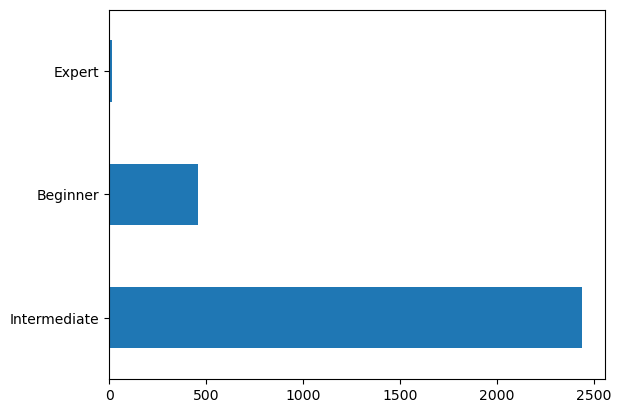

In [ ]:
# Sorted bv level
bigdf['Level'].value_counts().plot.barh()

<Axes: >

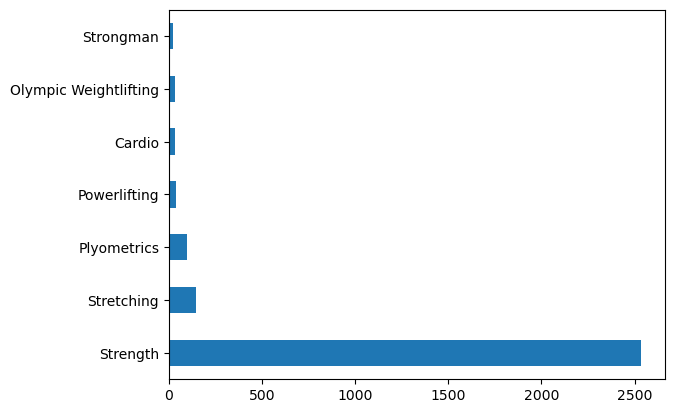

In [ ]:
# sorted by type
bigdf['Type'].value_counts().plot.barh()

<Axes: >

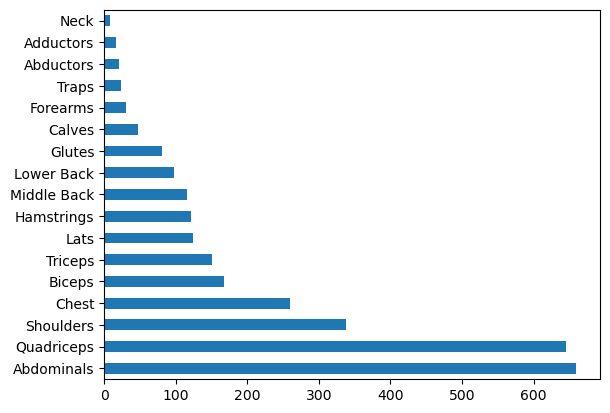

In [ ]:
# sorted by bodypart
bigdf['BodyPart'].value_counts().plot.barh()

In [ ]:
# top rated exercises
ratingSorted= bigdf.sort_values(by='Rating',ascending=False)
ratingSorted =ratingSorted.head(10)
ratingSorted

,index,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
1195,1195,Rickshaw Carry,NaN,Strongman,Forearms,Other,Beginner,9.6,Average
2065,2065,Single-Leg Press,The single-leg leg press is an exercise target...,Strength,Quadriceps,Machine,Intermediate,9.6,Average
1695,1695,T-Bar Row with Handle,NaN,Strength,Middle Back,Other,Intermediate,9.5,Average
731,731,Incline Hammer Curls,NaN,Strength,Biceps,Dumbbell,Beginner,9.5,Average
1179,1179,Palms-down wrist curl over bench,The palms-down wrist curl over bench is an exe...,Strength,Forearms,Barbell,Intermediate,9.5,Average
1577,1577,Atlas Stones,NaN,Strongman,Lower Back,Other,Intermediate,9.5,Average
1451,1451,Weighted pull-up,The weighted pull-up is a more advanced variat...,Strength,Lats,Other,Intermediate,9.5,Average
2525,2525,Dumbbell front raise to lateral raise,The dumbbell front raise to lateral raise is a...,Strength,Shoulders,Dumbbell,Intermediate,9.5,Average
1798,1798,Clean from Blocks,NaN,Olympic Weightlifting,Quadriceps,Barbell,Beginner,9.5,Average
88,88,Landmine twist,The landmine twist is a rotational abdominal m...,Strength,Abdominals,Other,Intermediate,9.5,Average


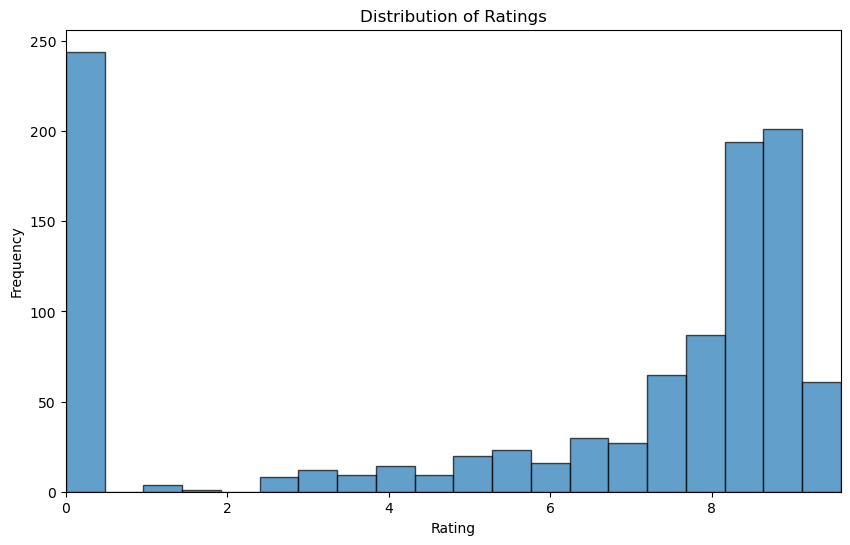

In [ ]:
# Distribution of ratings

df_sorted = bigdf.sort_values(by="Rating")
plt.figure(figsize=(10, 6))
plt.hist(df_sorted["Rating"], bins=20, edgecolor="k", alpha=0.7)

plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(False)
plt.xlim(df_sorted["Rating"].min(), df_sorted["Rating"].max())
plt.ylim(0, plt.gca().get_ylim()[1])
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from copy import deepcopy
import numpy as np

# Dataset for training. Converts all strings to categories (int) for KNN algorithm
x = deepcopy(bigdf)
x = x.drop(["Title"], axis = 1)
x = x.drop(["Desc"], axis = 1)
x = x.drop(["RatingDesc"], axis = 1)
x['Level'] = pd.factorize(x['Level'])[0]
x['Type'] = pd.factorize(x['Type'])[0]
x['BodyPart'] = pd.factorize(x['BodyPart'])[0]
x['Equipment'] = pd.factorize(x['Equipment'])[0]
x = x[x['Rating'].notna()]
x = x[bigdf["Rating"] != 0]

# Values to be predicted
y = x["Rating"]
x = x.drop(["Rating"], axis = 1)

# Grid search to find the best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15,17],
    'p': [1, 2]
}
grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x, y)
params = grid_search.best_params_

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)


# Training
knn = KNeighborsRegressor(n_neighbors = params['n_neighbors'], p = params["p"])
knn.fit(x_train, y_train)

pred = knn.predict(x_test)

print("Evaluating the prediction")
print(f"MAE: {mean_absolute_error(y_test, pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, pred):.2f}")
print(f"R-squared (R^2): {r2_score(y_test, pred):.2f}")


# New X, all exercises without ratings
x = deepcopy(bigdf)

# Excluding exercises with ratings
x = x[x['Rating'].isin([0, np.nan])]
x = x.drop(["Rating"], axis = 1)
x = x.drop(["Title"], axis = 1)
x = x.drop(["Desc"], axis = 1)
x = x.drop(["RatingDesc"], axis = 1)
x['Level'] = pd.factorize(x['Level'])[0]
x['Type'] = pd.factorize(x['Type'])[0]
x['BodyPart'] = pd.factorize(x['BodyPart'])[0]
x['Equipment'] = pd.factorize(x['Equipment'])[0]

# Amount of nonvalues
print("Nonvalues before:",bigdf["Rating"].isna().sum())

# All exercises without ratings are given a predicted rating
for index, row in x.iterrows():
    rating = knn.predict([row]).round(decimals=1)
    bigdf.loc[bigdf['index'] == index, 'Rating'] = rating

# Nonvalues after prediction
print("Nonvalues after",bigdf["Rating"].isna().sum())

filtered_df = bigdf[bigdf["Rating"] == 0]
print(len(filtered_df))


/var/folders/mk/8n8zy8bx2wg6sc_jvckk3g2c0000gn/T/ipykernel_14745/1548504529.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = x[bigdf["Rating"] != 0]
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thorsteinfougner/

Evaluating the prediction
MAE: 0.62
MSE: 1.13
R-squared (R^2): 0.50
Nonvalues before: 1884


/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with featur

Nonvalues after 0
0


/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with featur

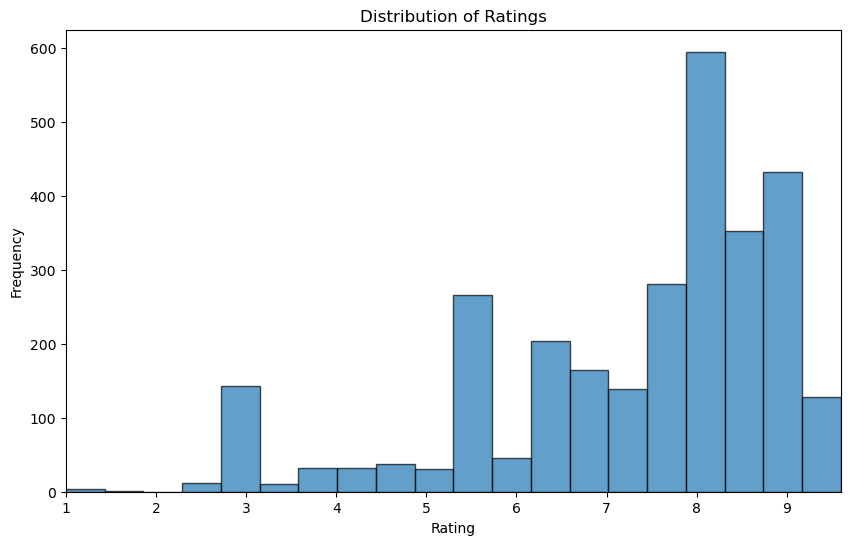

In [ ]:
# Ratings after KNN predicion

df_sorted = bigdf.sort_values(by="Rating")
plt.figure(figsize=(10, 6))
plt.hist(df_sorted["Rating"], bins=20, edgecolor="k", alpha=0.7)

plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(False)
plt.xlim(df_sorted["Rating"].min(), df_sorted["Rating"].max())
plt.ylim(0, plt.gca().get_ylim()[1])
plt.show()

In [ ]:
# Removing irrelevant columns
bigdf = bigdf.drop('RatingDesc', axis=1)
# Removing all rows containing nonvalues in description
bigdf = bigdf[bigdf['Desc'].notna()]
# Removing ID column
bigdf.pop(bigdf.columns[0])

# Dataset after preprocessing
clean_df = deepcopy(bigdf)

In [ ]:
clean_df

,Title,Desc,Type,BodyPart,Equipment,Level,Rating
0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,8.7
1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,Strength,Abdominals,Bands,Intermediate,8.7
2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,Strength,Abdominals,Bands,Intermediate,8.7
3,Banded crunch,The banded crunch is an exercise targeting the...,Strength,Abdominals,Bands,Intermediate,8.7
4,Crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,8.7
...,...,...,...,...,...,...,...
2911,Decline EZ-bar skullcrusher,The decline EZ-bar skullcrusher is a popular e...,Strength,Triceps,E-Z Curl Bar,Intermediate,9.3
2912,EZ-Bar Skullcrusher,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,9.0
2913,EZ-bar skullcrusher-,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,8.1
2915,EZ-Bar Skullcrusher - Gethin Variation,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,8.8


In [ ]:
# Smaller dataframe consisting of 120 exercises

smalldf = pd.read_csv("100_exercises.csv", sep=";", names = ["index", "Title"])
bigdf['Title'] = bigdf['Title'].str.lower()
smalldf['Title'] = smalldf['Title'].str.lower()
combined = pd.merge(bigdf, smalldf, on="Title", how='inner')

combined

,Title,Desc,Type,BodyPart,Equipment,Level,Rating,index
0,crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,8.7,7
1,decline plate sit-up,The decline plate sit-up is a weighted core ex...,Strength,Abdominals,Barbell,Intermediate,7.3,10
2,landmine twist,The landmine twist is a rotational abdominal m...,Strength,Abdominals,Other,Intermediate,9.5,11
3,single-arm bent-over rear delt fly,The single-arm bent-over rear delt fly is a po...,Strength,Abdominals,Other,Intermediate,8.3,12
4,kneeling cable crunch,The kneeling cable crunch is a popular core is...,Strength,Abdominals,Cable,Intermediate,8.9,14
...,...,...,...,...,...,...,...,...
109,single-arm cable triceps extension,The single-arm cable triceps extension is a si...,Strength,Triceps,Cable,Intermediate,8.9,115
110,dip machine,The dip machine is a machine exercise that mim...,Strength,Triceps,Cable,Intermediate,8.8,116
111,cable overhead triceps extension,The cable overhead triceps extension is a cabl...,Strength,Triceps,Cable,Intermediate,8.1,117
112,reverse-grip cable straight-bar push-down,The reverse-grip cable straight-bar push-down ...,Strength,Triceps,Cable,Intermediate,7.9,118


<h1>Cosine similarity</h1>

In [ ]:
# Prints the row of the given Title to find the index
print(bigdf[bigdf["Title"] == "bench press"])

           Title                                               Desc      Type  \
942  bench press  The bench press is a popular barbell exercise ...  Strength   

    BodyPart Equipment         Level  Rating  
942    Chest   Barbell  Intermediate     7.2  


In [ ]:
# Merging columns for cosign similarity and dropping excess columns
bigdf["Merged"] = bigdf["Type"].astype(str) + '|' + \
  bigdf["BodyPart"].astype(str) + '|' + bigdf["Equipment"].astype(str) + '|' + \
  bigdf["Level"]

bigdf = bigdf.drop('Type', axis=1)
bigdf = bigdf.drop('BodyPart', axis=1)
bigdf = bigdf.drop('Equipment', axis=1)
bigdf = bigdf.drop('Level', axis=1)

# The merged columns
bigdf["Merged"]

0           Strength|Abdominals|Bands|Intermediate
1           Strength|Abdominals|Bands|Intermediate
2           Strength|Abdominals|Bands|Intermediate
3           Strength|Abdominals|Bands|Intermediate
4           Strength|Abdominals|Bands|Intermediate
                           ...                    
2911    Strength|Triceps|E-Z Curl Bar|Intermediate
2912    Strength|Triceps|E-Z Curl Bar|Intermediate
2913    Strength|Triceps|E-Z Curl Bar|Intermediate
2915    Strength|Triceps|E-Z Curl Bar|Intermediate
2916    Strength|Triceps|E-Z Curl Bar|Intermediate
Name: Merged, Length: 1359, dtype: object

In [ ]:
# Converting values of the merged column into vectors

from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
count_matrix = count.fit_transform(bigdf.loc[:,"Merged"])

liste = count_matrix.toarray()

In [ ]:
# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(count_matrix, count_matrix)

In [ ]:
#sim_matrix

In [ ]:
# Resetting the index to avoid indexing errors and NAN values in recommender
# This makes the previous indexes invalid
# "drop" avoids adding the old index as a column
bigdf = bigdf.reset_index(drop = False)

In [ ]:
def recommender(data_frame, exercise_id, sim_matrix):
    sim_df = pd.DataFrame(sim_matrix[exercise_id],
                         columns=["Similarity"])
    exercise_titles = data_frame.loc[:, "Title"]
    exercise_rec = pd.concat([sim_df, exercise_titles], axis = 1)
    exercise_rec = exercise_rec.sort_values(by="Similarity", ascending=False)
    
    return exercise_rec

In [ ]:
# Prints the row of the given Title to find the index
print(bigdf[bigdf["Title"] == "bench press"])

     index        Title                                               Desc  \
450    942  bench press  The bench press is a popular barbell exercise ...   

     Rating                               Merged  
450     7.2  Strength|Chest|Barbell|Intermediate  


In [ ]:
# Exercises similar to bench press
df_by_cat = recommender(bigdf, 450, sim_matrix)
df_by_cat

,Similarity,Title
449,1.0,incline bench press
457,1.0,spoto press
448,1.0,paul carter incline bench press
451,1.0,tbs close-grip bench press
452,1.0,am flat bench barbell press
...,...,...
677,0.0,alternating lunge jump
412,0.0,calf smr
1215,0.0,bar shoulder extension stretch
676,0.0,lying hamstring stretch with band


<h1>TDIDF</h1>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
tfidf = TfidfVectorizer(stop_words="english")
overview_matrix = tfidf.fit_transform(bigdf["Desc"])
overview_matrix.shape

(1359, 1918)

In [ ]:
similarity_matrix = linear_kernel(overview_matrix, overview_matrix)
print(similarity_matrix[0:5,0:5])

[[1.         0.1544238  0.15958079 0.16654907 0.12296181]
 [0.1544238  1.         0.13114796 0.92719703 0.21069057]
 [0.15958079 0.13114796 1.         0.14144562 0.00427982]
 [0.16654907 0.92719703 0.14144562 1.         0.22723387]
 [0.12296181 0.21069057 0.00427982 0.22723387 1.        ]]


In [ ]:
mapping = pd.Series(bigdf.index, index = bigdf["Desc"])
mapping

Desc
The partner plank band row is an abdominal exercise where two partners perform single-arm planks while pulling on the opposite ends of an exercise band. This technique can be done for time or reps in any ab-focused workout.                                                                                                                                                0
The banded crunch isometric hold is an exercise targeting the abdominal muscles, particularly the rectus abdominis or "six-pack" muscles. The band adds resistance and continuous tension to this popular exercise.                                                                                                                                                            1
The banded plank jack is a variation on the plank that involves moving the legs in and out for repetitions. Having a band around the thighs forces the lower body to work harder, particularly the hips and glutes. The plank jack is commonly performed as part 

In [1]:
def recommender_by_desc(exercise_input, df, similarity_matrix, mapping):
    exercise_index = mapping[exercise_input]
    if not isinstance(exercise_index, np.int64):
        exercise_index = exercise_index[0]
    similarity_score = list(enumerate(similarity_matrix[exercise_index]))
    score = [tup[1] for tup in similarity_score]
    exercise_indices = [i[0] for i in similarity_score]
    df2 = df["Title"].iloc[exercise_indices].to_frame()
    df2["Similarity"] = score
    return df2


In [ ]:
df_by_desc = recommender_by_desc(bigdf["Desc"][450], bigdf, similarity_matrix, mapping)
df_by_desc.sort_values(by="Similarity", ascending=False).iloc[:10]

,Title,Similarity
450,bench press,1.000000
452,am flat bench barbell press,0.513020
455,king maker barbell bench press,0.513020
453,up bench press,0.513020
442,barbell bench press - medium grip,0.513020
441,close-grip bench press,0.405098
1154,alternating standing shoulder press,0.326917
557,dumbbell bench press-,0.321061
446,board bench press,0.320781
507,smith machine bench press,0.306428


<h1>Combined recommender (Cosine similarity + TDIDF)</h1>

In [ ]:
merged_df = df_by_cat.copy()
merged_df["Similarity"] = (df_by_cat["Similarity"] + df_by_desc["Similarity"]) / 2
merged_df = merged_df.sort_values(by=["Similarity"], ascending=False)
merged_df[0:10]

,Similarity,Title
450,1.000000,bench press
452,0.756510,am flat bench barbell press
453,0.756510,up bench press
442,0.756510,barbell bench press - medium grip
455,0.756510,king maker barbell bench press
441,0.702549,close-grip bench press
457,0.648426,spoto press
443,0.648245,decline barbell bench press
449,0.644439,incline bench press
448,0.616737,paul carter incline bench press


<h1>Constraint based recommender</h1>

In [ ]:
# Dataframe without merged columns
df = deepcopy(clean_df)

def knowledge_based_rec(dataframe, type=None, bodypart=None, equipment=None, level=None):
    #return dataframe

    if type:
        dataframe = dataframe[dataframe["Type"] == type]
    if bodypart:
        dataframe = dataframe[dataframe["BodyPart"] == bodypart]
    if equipment:
        dataframe = dataframe[dataframe["Equipment"] == equipment]
    if level:
        dataframe = dataframe[dataframe["Level"] == level]

    recommendations = dataframe[["Title" , "Rating"]]
    return recommendations.sort_values(by="Rating", ascending=False).iloc[:10]

print(knowledge_based_rec(df, type="", bodypart="Chest", equipment="Barbell", level=""))

                                       Title  Rating
927                   Close-grip bench press     9.1
928        Barbell Bench Press - Medium Grip     9.0
929              Decline barbell bench press     8.9
930                    Wide-grip bench press     8.9
932  Barbell Incline Bench Press Medium-Grip     8.8
952                              Spoto press     8.0
935                        Board bench press     7.7
936            Barbell Bench Press-Wide Grip     7.6
940          Paul Carter Incline Bench Press     7.2
942                              Bench press     7.2


In [ ]:
# SMALL DATAFRAME
df = deepcopy(combined)
def knowledge_based_rec(dataframe, type=None, bodypart=None, equipment=None, level=None):
    if type:
        dataframe = dataframe[df["Type"] == type]
    if bodypart:
        dataframe = dataframe[df["BodyPart"] == bodypart]
    if equipment:
        dataframe = dataframe[df["Equipment"] == equipment]
    if level:
        dataframe = dataframe[df["Level"] == level]

    recommendations = dataframe[["Title" , "Rating"]]
    return recommendations.sort_values(by="Rating", ascending=False).iloc[:10]

print(knowledge_based_rec(df, type="", bodypart="Chest", equipment="Barbell", level=""))

                          Title  Rating
22       close-grip bench press     9.1
23  decline barbell bench press     8.9
24        wide-grip bench press     8.9
25          incline bench press     7.2
26                  bench press     7.2


/var/folders/mk/8n8zy8bx2wg6sc_jvckk3g2c0000gn/T/ipykernel_14745/180625733.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataframe = dataframe[df["Equipment"] == equipment]


<h1>Knowledge based GUI</h1>

In [ ]:
combined

,Title,Desc,Type,BodyPart,Equipment,Level,Rating,index
0,crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,8.7,7
1,decline plate sit-up,The decline plate sit-up is a weighted core ex...,Strength,Abdominals,Barbell,Intermediate,7.3,10
2,landmine twist,The landmine twist is a rotational abdominal m...,Strength,Abdominals,Other,Intermediate,9.5,11
3,single-arm bent-over rear delt fly,The single-arm bent-over rear delt fly is a po...,Strength,Abdominals,Other,Intermediate,8.3,12
4,kneeling cable crunch,The kneeling cable crunch is a popular core is...,Strength,Abdominals,Cable,Intermediate,8.9,14
...,...,...,...,...,...,...,...,...
109,single-arm cable triceps extension,The single-arm cable triceps extension is a si...,Strength,Triceps,Cable,Intermediate,8.9,115
110,dip machine,The dip machine is a machine exercise that mim...,Strength,Triceps,Cable,Intermediate,8.8,116
111,cable overhead triceps extension,The cable overhead triceps extension is a cabl...,Strength,Triceps,Cable,Intermediate,8.1,117
112,reverse-grip cable straight-bar push-down,The reverse-grip cable straight-bar push-down ...,Strength,Triceps,Cable,Intermediate,7.9,118


In [ ]:
import pandas as pd
import tkinter as tk
from tkinter import ttk

# Load your gym exercise data into a Pandas DataFrame
# Make sure to specify the correct encoding if you have special characters
df = deepcopy(combined)

# Create a tkinter GUI
root = tk.Tk()
root.title("Gym Exercise Recommender")

# Function to filter and display exercises
def recommend_exercises():
    selected_bodypart = bodypart_var.get()
    selected_level = level_var.get()
    selected_type = type_var.get()

    filtered_df = df[
        (df['BodyPart'] == selected_bodypart) &
        (df['Level'] == selected_level) &
        (df['Type'] == selected_type)
    ]

    exercise_list.delete(0, tk.END)  # Clear the listbox

    for i, title in enumerate(filtered_df['Title']):
        exercise_list.insert(tk.END, f'{i + 1}. {title}')

# Create and configure GUI elements
bodypart_label = ttk.Label(root, text="Select Body Part:")
bodypart_label.pack()
my_bps = [i for i in df["BodyPart"].unique()]
bodypart_var = ttk.Combobox(root, values=my_bps)
bodypart_var.pack()

level_label = ttk.Label(root, text="Select Level:")
level_label.pack()
my_levels = [i for i in df["Level"].unique()]
level_var = ttk.Combobox(root, values=my_levels)
level_var.pack()

type_label = ttk.Label(root, text="Select Type:")
type_label.pack()
my_types = [i for i in df["Type"].unique()]
type_var = ttk.Combobox(root, values=my_types)
type_var.pack()

recommend_button = ttk.Button(root, text="Recommend Exercises", command=recommend_exercises)
recommend_button.pack()

exercise_list = tk.Listbox(root)
exercise_list.pack()

root.mainloop()

In [ ]:
"""
import pandas as pd
import tkinter as tk
from tkinter import ttk

# Load your gym exercise data into a Pandas DataFrame
# Make sure to specify the correct encoding if you have special characters
df = deepcopy(clean_df)

# Create a tkinter GUI
root = tk.Tk()
root.title("Gym Exercise Recommender")

# Function to filter and display exercises
def recommend_exercises():
    selected_bodypart = bodypart_var.get()
    selected_level = level_var.get()
    selected_type = type_var.get()

    filtered_df = df[
        (df['BodyPart'] == selected_bodypart) &
        (df['Level'] == selected_level) &
        (df['Type'] == selected_type)
    ]

    exercise_list.delete(0, tk.END)  # Clear the listbox

    for i, title in enumerate(filtered_df['Title']):
        exercise_list.insert(tk.END, f'{i + 1}. {title}')

# Create and configure GUI elements
bodypart_label = ttk.Label(root, text="Select Body Part:")
bodypart_label.pack()
my_bps = [i for i in df["BodyPart"].unique()]
bodypart_var = ttk.Combobox(root, values=my_bps)
bodypart_var.pack()

level_label = ttk.Label(root, text="Select Level:")
level_label.pack()
my_levels = [i for i in df["Level"].unique()]
level_var = ttk.Combobox(root, values=my_levels)
level_var.pack()

type_label = ttk.Label(root, text="Select Type:")
type_label.pack()
my_types = [i for i in df["Type"].unique()]
type_var = ttk.Combobox(root, values=my_types)
type_var.pack()

recommend_button = ttk.Button(root, text="Recommend Exercises", command=recommend_exercises)
recommend_button.pack()

exercise_list = tk.Listbox(root)
#exercise_list.pack()

#root.mainloop() """

<h1>Collaborative</h1>

In [ ]:
# Collaborative filtering
"""
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader

ratings_df = pd.read_csv("user_ratings.csv")
ratings = ratings_df.melt(id_vars=['Users'], var_name='Exercise', value_name='Rating')
ratings.to_csv("ratings2.csv")

ratings = pd.read_csv("ratings2.csv")
ratings = ratings.drop("Unnamed: 0", axis=1)
ratings['Exercise'] = pd.factorize(ratings['Exercise'])[0]

# Use ratings DataFrame for pivoting
ratings_full = ratings.pivot(index="Users", columns="Exercise", values="Rating")

# Now you can use ratings_full for further analysis
ratings_full"""

In [6]:
# Collaborative filtering
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader
import pandas as pd
import numpy as np

# Leser DataFrame
ratings_df = pd.read_csv("user_ratings.csv")

# Converting to the correct format
ratings = ratings_df.melt(id_vars=['Users'], var_name='Exercise', value_name='Rating')

# Factorization?
ratings['Exercise'] = pd.factorize(ratings['Exercise'])[0]
# Use ratings DataFrame for pivoting
ratings = ratings.fillna(0).astype(int)
# Training

reader = Reader(rating_scale=(1.0,10.0))
data = Dataset.load_from_df(ratings[["Users", "Exercise", "Rating"]], reader)
trainset = data.build_full_trainset()

# Variables
user_rating = trainset.ur
item_rating = trainset.ir
num_users = trainset.n_users
num_items = trainset.n_items
num_ratings = trainset.n_ratings

print("Users", num_users)
print("Items", num_items)
print("Ratings", num_ratings)
density = num_ratings / (num_users * num_items) 
density = np.round(density, decimals=2)
sparsity = 1 - density
print("Density:", density*100, "%")
print("Sparsity:", sparsity*100, "%")


sim_options = {"name": "pearson",
               "user based": True,
               "shrinkage": 0}

rec = KNNBasic(sim_options=sim_options)
rec.fit(trainset)

user_sim_matrix = rec.sim
#user_sim_matrix
ratings

Users 18
Items 120
Ratings 2160
Density: 100.0 %
Sparsity: 0.0 %
Computing the pearson similarity matrix...
Done computing similarity matrix.


,Users,Exercise,Rating
0,1.0,0.0,0.0
1,2.0,0.0,0.0
2,3.0,0.0,0.0
3,4.0,0.0,0.0
4,5.0,0.0,10.0
...,...,...,...
2155,14.0,119.0,0.0
2156,15.0,119.0,0.0
2157,16.0,119.0,0.0
2158,17.0,119.0,0.0


In [ ]:
# USER BASED + EVALUATION


#Import the train_test_split function
from sklearn.model_selection import train_test_split

#Assign X as the original ratings dataframe and y as the user_id column of ratings.
X = ratings.copy()
y = ratings['Users']

#Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=42)

## Stratified random sampling: is a method to ensure that each sample it's likely to occur in after the split.
## random_state: 
r_matrix = X_train.pivot_table(values='Rating', index='Users', columns='Exercise')
r_matrix = r_matrix.fillna(0).astype(int)
print(r_matrix.head())

def cf_user_mean(user, exercise):
    
    #Check if movie_id exists in r_matrix
    if exercise in r_matrix:
        #Compute the mean of all the ratings given to the movie
        mean_rating = r_matrix[exercise].mean() 
    else:
        #Default to a rating of 3.0 in the absence of any information
        mean_rating = 5.0
    
    return mean_rating

#Import the mean_squared_error function
from sklearn.metrics import mean_squared_error

#Function that computes the root mean squared error (or RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#Function to compute the RMSE score obtained on the testing set by a model
def score(cf_model):
    
    #Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(X_test['Users'], X_test['Exercise'])
    
    #Predict the rating for every user-movie tuple
    y_pred = np.array([cf_model(User, Exercise) for (User, Exercise) in id_pairs])
    
    
    #Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test['Rating'])
    
    #Return the final RMSE score
    return rmse(y_true, y_pred)

#Define the baseline model to always return 3.
def baseline(User, Exercise):
    return 5


print(score(baseline))
print(score(cf_user_mean))

In [ ]:
# Model Based
ratings.head(50)

<h1>Evaluation</h1>

In [ ]:
#Evaluation

from eval_metrics import precision_recall_at_k
from surprise import SVD
from surprise import SVDpp
from surprise import KNNBaseline
from surprise import BaselineOnly
from surprise import NormalPredictor
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from tabulate import tabulate

ratings_df = pd.read_csv("user_ratings.csv")

# Converting to the correct format
ratings = ratings_df.melt(id_vars=['Users'], var_name='Exercise', value_name='Rating')

# Factorization?
ratings['Exercise'] = pd.factorize(ratings['Exercise'])[0]
# Use ratings DataFrame for pivoting
ratings = ratings.fillna(0).astype(int)
# Training

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings.iloc[:,0:3], reader)

trainset, testset = train_test_split(data, test_size=0.3)

table = []
rec_n = 0

recommenders = (SVD, SVDpp, KNNBasic, KNNBaseline, BaselineOnly, NormalPredictor)
titles = ("SVD", "SVD++", "KNN-Basic", "KNN-Baseline", "Baseline", "Random")

for rec in recommenders:
    rec_alg = rec()
    rec_alg.fit(trainset)
    predictions = rec_alg.test(testset)

    p, r = precision_recall_at_k(predictions, k=4, threshold=4)
    precision = "{:.3f}".format(p)
    recall = "{:.3f}".format(r)

    new_line = [titles[rec_n], precision, recall]
    table.append(new_line)
    rec_n += 1

header = ["recommenders", "precision", "recall"]
print(tabulate(table, header, tablefmt="pipe"))
#print(ratings.head(20))

In [ ]:
ratings_df = pd.read_csv("user_ratings.csv")

# Converting to the correct format
ratings = ratings_df.melt(id_vars=['Users'], var_name='Exercise', value_name='Rating')

# Factorization?
ratings['Exercise'] = pd.factorize(ratings['Exercise'])[0]
# Use ratings DataFrame for pivoting
ratings = ratings.fillna(0).astype(int)
# Training

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings.iloc[:,0:3], reader)

kf = KFold(random_state=0)

table = []
fold_n = 0
for rec in recommenders:
    out = cross_validate(rec(), data, ["rmse", "mae", "fcp",], kf)
    mean_rmse = "{:.3f}".format(np.mean(out["test_rmse"]))
    mean_mae = "{:.3f}".format(np.mean(out["test_mae"]))
    mean_fcp = "{:.3f}".format(np.mean(out["test_fcp"]))
    fit_time = "{:.3f}".format(np.mean(out["fit_time"]))

    new_line = [titles[fold_n], mean_rmse, mean_mae, mean_fcp, fit_time]
    table.append(new_line)
    fold_n += 1

In [ ]:
header = ["Recommenders", "Pred Accuracy [RMSE]", "Pred Accuracy [MAE]", "Pred Accuracy [FCP]", "Training Time [sec]"]
print(tabulate(table, header, tablefmt="pipe"))